In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import os
import shutil
from pathlib import Path

import aps_ai
import aps_ai.beamline34IDC.optimization.common as opt_common
import aps_ai.beamline34IDC.optimization.configs as configs
import aps_ai.beamline34IDC.optimization.movers as movers
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from aps_ai.beamline34IDC.facade.focusing_optics_factory import ExecutionMode, focusing_optics_factory_method
from aps_ai.beamline34IDC.facade.focusing_optics_interface import AngularUnits, DistanceUnits, Movement
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement, get_default_input_features
from aps_ai.common.util import clean_up
from aps_ai.common.util.shadow.common import (
    EmptyBeamException,
    PreProcessorFiles,
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from aps_ai.common.util.wrappers import PlotMode
from Shadow.ShadowTools import focnew
from skopt.callbacks import DeadlineStopper, DeltaXStopper, DeltaYStopper
from test_optuna_qnehvi import BoTorchSampler, qnehvi_candidates_func
from tqdm import tqdm

%matplotlib inline

In [117]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

41814


In [118]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809


In [119]:
root_dir = Path(aps_ai.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'34-ID'
temp_work_dir = base_dir / f'tmp_work_dir_34-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [120]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [121]:
os.chdir(temp_work_dir)

In [122]:
input_beam_path = "primary_optics_system_beam.dat"

In [123]:
move_motors_ranges = {'hkb_1': [-30, 30], 
                      'vkb_1': [-30, 30],
                      'hkb_2': [-30, 30],
                      'vkb_2': [-30, 30],
                      'hkb_3': [-0.04, 0.04],
                      'vkb_3': [-0.04, 0.04],
                      'hkb_4': [-30, 30], 
                      'vkb_4': [-30, 30]}

In [10]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-75809

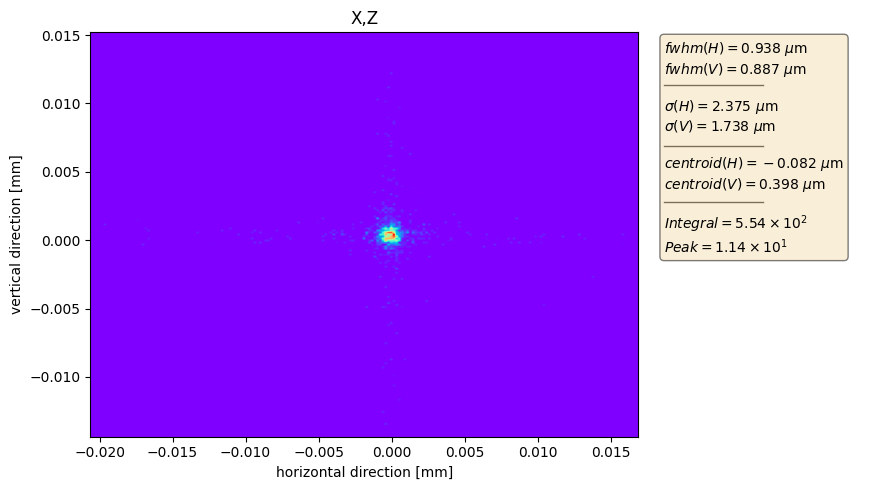

In [11]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

In [12]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [13]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [14]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [45]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    opt_platform = "optuna"

    def set_optimizer_options(
        self,
        motor_ranges: list = None,
        base_sampler: optuna.samplers.BaseSampler = None,
        directions: str = None,
        integral_threshold: float = 1e2,
        raise_prune_exception: bool = True,
        use_discrete_space: bool = True,
        **extra_options
    ):

        self.motor_ranges = self._get_guess_ranges(motor_ranges)

        if base_sampler is None:
            # if self.multi_objective_optimization:
            #    base_sampler = optuna.samplers.MOTPESampler()
            # else:
            base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        self._raise_prune_exception = raise_prune_exception

        if directions is None:
            directions = ["minimize"] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions

        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0.0 for mt in self.motor_types})

        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        self.integral_threshold = integral_threshold
        self._use_discrete_space = use_discrete_space

        self.best_params = {k: 0.0 for k in self.motor_types}

    def _objective(self, trial, step_scale: float = 1):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            if self._use_discrete_space:
                resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
                current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution * step_scale))
            else:
                current_params.append(trial.suggest_float(mot, r[0], r[1]))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            if np.nan in loss and self._raise_prune_exception:
                raise optuna.TrialPruned
            loss[np.isnan(loss)] = 1e4

            if self.integral_threshold is not None:
                if self.beam_state.hist.data_2D.sum() < self.integral_threshold:
                    if self._raise_prune_exception:
                        raise optuna.TrialPruned
                    else:
                        return [1e4] * len(self._loss_function_list)

            for k in ["sigma", "fwhm"]:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0:
                        loss[width_idx] = 1e4
            loss = list(loss)

        rads = (self.beam_state.hist.hh**2 + self.beam_state.hist.vv**2) ** 0.5
        weighted_sum_ints = np.sum(self.beam_state.hist.data_2D * rads)
        trial.set_user_attr("wsum", weighted_sum_ints)

        return loss

    def trials(self, n_trials: int, trial_motor_types: list = None, step_scale: float = 1):
        
        obj_this = lambda t: self._objective(t, step_scale=step_scale)
        
        if trial_motor_types is None:
            self.study.optimize(obj_this, n_trials)

        else:

            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(obj_this, n_trials=n_trials)

            self.study.sampler = self._base_sampler

        self.best_params.update(self.study.best_trials[0].params)

    # def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass

    def _optimize(self):
        pass

    # def set_optimizer_options(self):
    #    pass

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


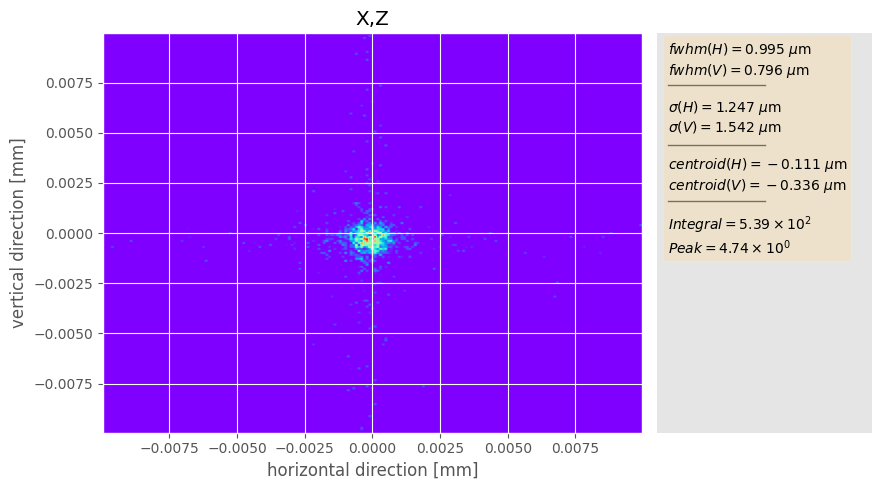

In [124]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [125]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.0004208144015713824, 0.0029922976962746357)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/D

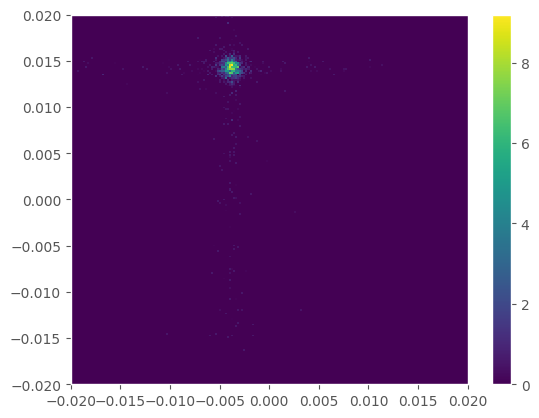

In [126]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.02, 0.02],
    yrange=[-0.02, 0.02],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [127]:
hist.data_2D.sum()

538.5910754802118

In [128]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
0.014067553569209516 0.005860768236302687


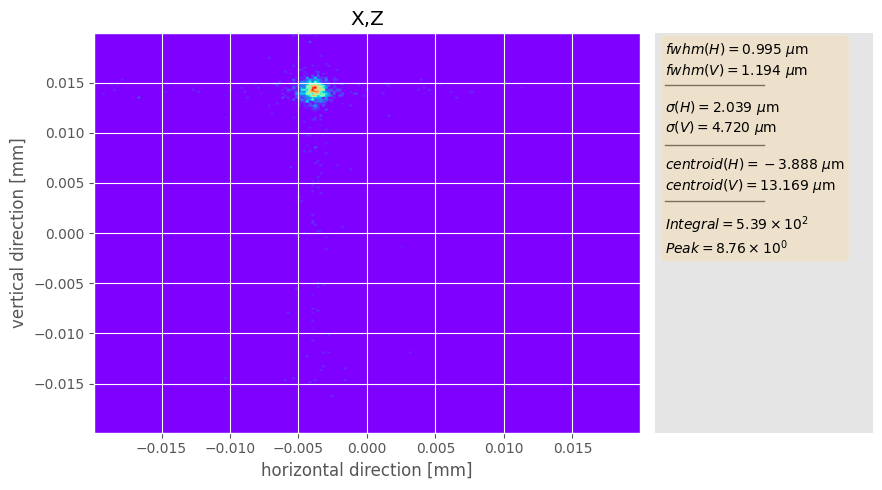

In [129]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.02, 0.02],
    yrange=[-0.02, 0.02],
    nbins=201,
)

In [130]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.02, 0.02],
                            camera_yrange=[-0.02, 0.02],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [131]:
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-3e-3]}, seed=111)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/4219517420.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-3e-3]}, seed=111)


In [132]:
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    integral_threshold=100,
    base_sampler=base_sampler,
    raise_prune_exception=True,
    use_discrete_space=True
)

[I 2022-10-15 23:39:26,409] A new study created in memory with name: no-name-2cb75242-2a7b-46fd-a79a-087e0b13ab55


In [133]:
opt_trial.trials(50, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/2085722336.py:85: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

In [134]:
opt_trial.study.best_trials

[FrozenTrial(number=21, values=[0.008281520307189157, 0.002690356956194155], datetime_start=datetime.datetime(2022, 10, 15, 23, 40, 38, 691019), datetime_complete=datetime.datetime(2022, 10, 15, 23, 40, 40, 262312), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.012074731968090727, 'hkb_4': -8.299999999999997, 'vkb_4': -1.6999999999999993}, distributions={'hkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, 

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


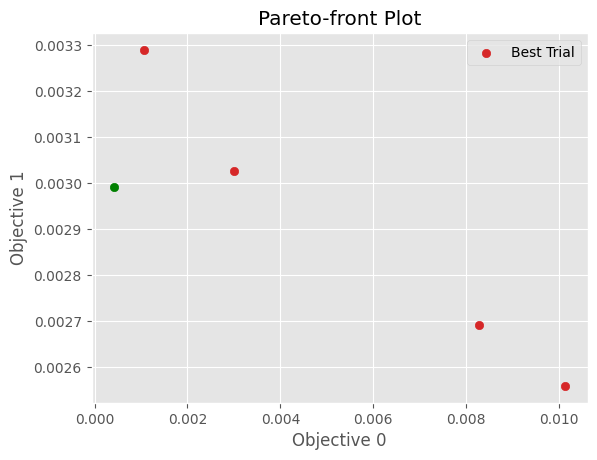

In [135]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [136]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-10.71181011216219 5.425451996537746
-11.607808220655986 1.5976421549678825
-10.560760231802629 4.354181258242725
-12.55635113274176 1.1930336896236626


[0.008281520307189157, 0.002690356956194155] 5.425451996537746


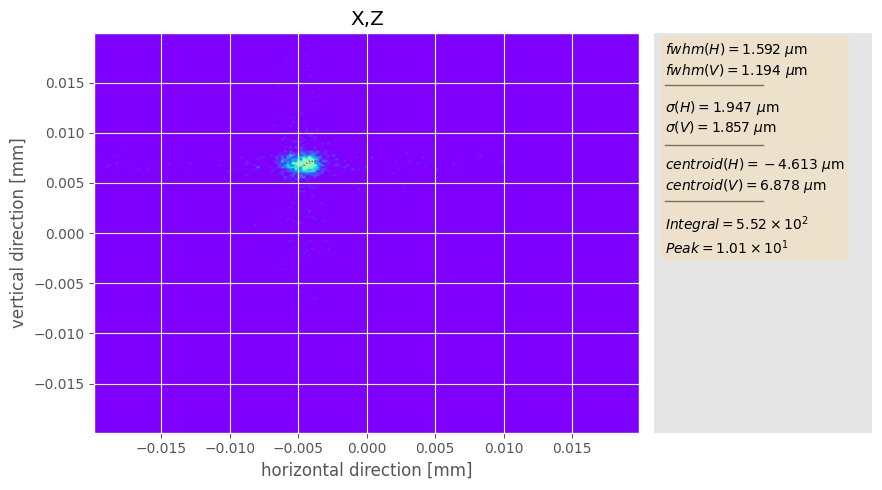

[0.0030056225373901947, 0.0030259274017638334] 1.5976421549678825


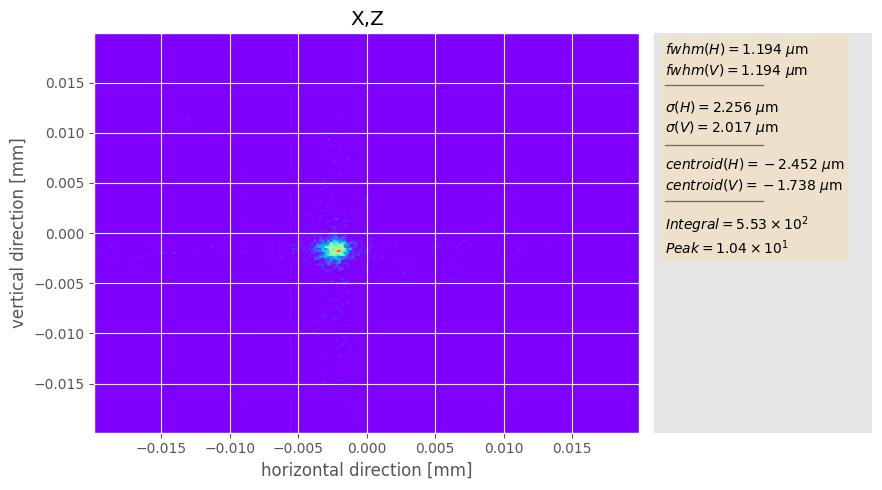

[0.0101281527448441, 0.0025585261740202108] 4.354181258242725


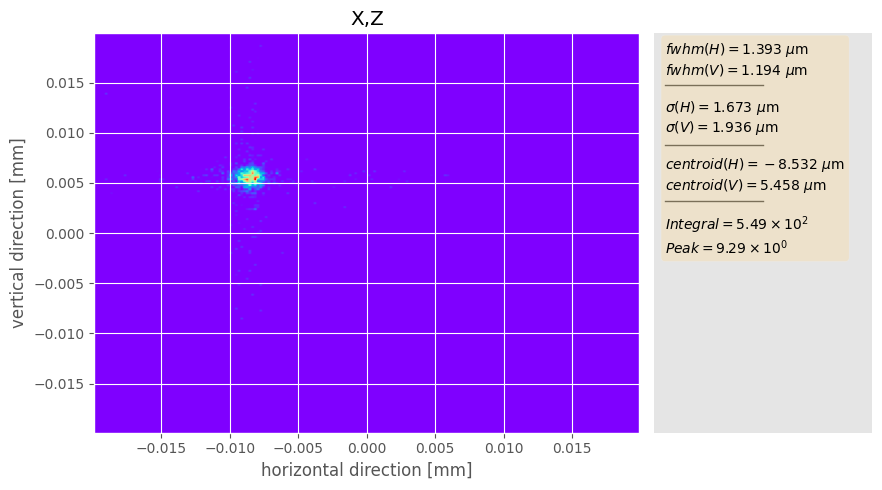

[0.001070792059873611, 0.003289582995713817] 1.1930336896236626


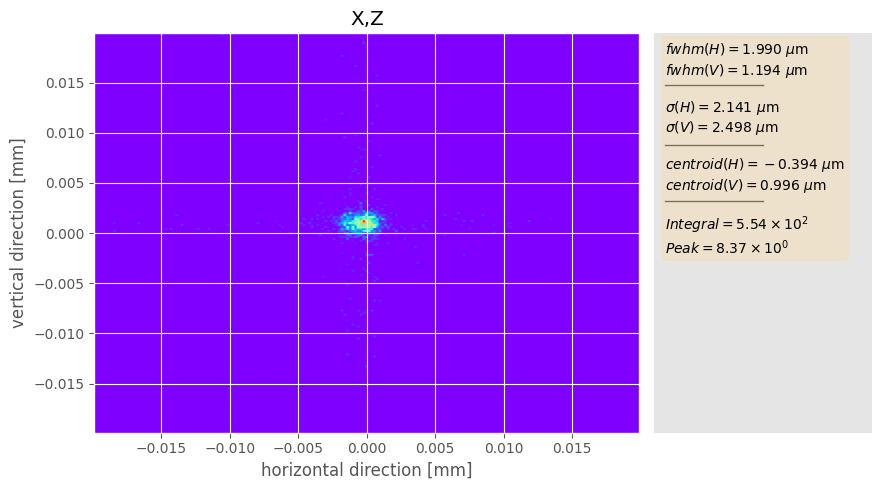

In [137]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [139]:
opt_trial.trials(50)

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:42:47,633] Trial 50 finished with values: [0.0126497295446542, 0.0029523795019567264] and parameters: {'hkb_1': -0.39800000000000324, 'vkb_1': 13.179499999999997, 'hkb_2': 5.212999999999994, 'vkb_2': 8.1162, 'hkb_3': 0.02981317007977318, 'vkb_3': -0.012074731968090727, 'hkb_4': -9.7, 'vkb_4': -11.099999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:42:50,917] Trial 51 finished with values: [0.004081109239844166, 0.0032582981114563712] and parameters: {'hkb_1': -0.9206000000000039, 'vkb_1': 22.075599999999994, 'hkb_2': 0.5554999999999986, 'vkb_2': 2.4195999999999955, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.003348085708119078, 'hkb_4': -8.7, 'vkb_4': -8.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:42:54,593] Trial 52 finished with values: [0.006350663721099117, 0.003267673799556825] and parameters: {'hkb_1': 0.6354999999999968, 'vkb_1': 16.978499999999997, 'hkb_2': 7.166899999999998, 'vkb_2': -1.2856000000000023, 'hkb_3': -0.00509341496011341, 'vkb_3': -0.019056048976068045, 'hkb_4': -12.399999999999999, 'vkb_4': -5.399999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.99999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:42:59,088] Trial 53 finished with values: [0.004180258166371906, 0.0033081111128602943] and parameters: {'hkb_1': 6.727399999999996, 'vkb_1': 28.315399999999997, 'hkb_2': -1.8454000000000015, 'vkb_2': -3.4959000000000024, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.008869219055841225, 'hkb_4': -0.5, 'vkb_4': -13.3}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:02,998] Trial 54 finished with values: [0.007105931129573221, 0.0031384296933568675] and parameters: {'hkb_1': 3.5349000000000004, 'vkb_1': 5.283299999999997, 'hkb_2': -11.3947, 'vkb_2': -6.055000000000003, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.0001425727958695791, 'hkb_4': -10.299999999999997, 'vkb_4': -10.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:06,541] Trial 55 finished with values: [0.007500380728133583, 0.003163549283868087] and parameters: {'hkb_1': 1.7372999999999976, 'vkb_1': 23.415899999999993, 'hkb_2': -12.530800000000003, 'vkb_2': -6.703100000000003, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.020801378228062377, 'hkb_4': 0.7000000000000028, 'vkb_4': -8.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:10,475] Trial 56 finished with values: [0.005970208544250734, 0.0031461136392798602] and parameters: {'hkb_1': -7.245700000000003, 'vkb_1': 8.915399999999998, 'hkb_2': -18.3825, 'vkb_2': 7.660599999999995, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.015565390472079388, 'hkb_4': -2.8999999999999986, 'vkb_4': -12.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:14,200] Trial 57 finished with values: [0.002903659423724191, 0.0044029915039489696] and parameters: {'hkb_1': 21.160599999999995, 'vkb_1': 15.841099999999997, 'hkb_2': -8.682900000000004, 'vkb_2': -15.362800000000002, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.003348085708119078, 'hkb_4': 1.6000000000000014, 'vkb_4': -11.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:17,497] Trial 58 finished with values: [0.00550135579681005, 0.0031235122188802643] and parameters: {'hkb_1': 8.4621, 'vkb_1': 21.197699999999998, 'hkb_2': -26.9169, 'vkb_2': 6.767099999999999, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.013820061220085056, 'hkb_4': -1.6999999999999993, 'vkb_4': -10.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:21,205] Trial 59 finished with values: [0.01015955884473522, 0.0028406618669873564] and parameters: {'hkb_1': 16.058099999999996, 'vkb_1': 4.578199999999995, 'hkb_2': -9.047, 'vkb_2': -0.03490000000000393, 'hkb_3': 0.0001425727958695791, 'vkb_3': -0.017310719724073716, 'hkb_4': -13.3, 'vkb_4': -10.799999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:25,341] Trial 60 finished with values: [0.0009066279590175685, 0.0031183438880061456] and parameters: {'hkb_1': 9.075699999999998, 'vkb_1': 14.420499999999997, 'hkb_2': -7.160600000000002, 'vkb_2': 0.9112999999999971, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.006838744212107742, 'hkb_4': -2.5, 'vkb_4': -11.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:28,942] Trial 61 finished with values: [0.006634129732827841, 0.002934423117660832] and parameters: {'hkb_1': 6.252899999999997, 'vkb_1': -13.914800000000003, 'hkb_2': -20.4362, 'vkb_2': -14.7055, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.006838744212107742, 'hkb_4': -8.099999999999998, 'vkb_4': -5.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:31,914] Trial 62 finished with values: [0.0006057016859658535, 0.0029244586929743606] and parameters: {'hkb_1': 11.376099999999994, 'vkb_1': 13.016099999999994, 'hkb_2': -10.180200000000003, 'vkb_2': 20.244799999999998, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.015565390472079388, 'hkb_4': -10.599999999999998, 'vkb_4': -7.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:35,347] Trial 63 finished with values: [0.0015709742426541337, 0.003192028409656824] and parameters: {'hkb_1': 21.137299999999996, 'vkb_1': 20.019999999999996, 'hkb_2': -20.6412, 'vkb_2': 14.550699999999999, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.017310719724073716, 'hkb_4': -9.899999999999999, 'vkb_4': -4.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:39,097] Trial 64 finished with values: [0.0013436395175152637, 0.0029365531755643115] and parameters: {'hkb_1': 8.363699999999994, 'vkb_1': 13.554599999999994, 'hkb_2': -14.651900000000001, 'vkb_2': 3.758099999999999, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.015565390472079388, 'hkb_4': -11.399999999999999, 'vkb_4': -5.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:43,164] Trial 65 finished with values: [0.004924785401140301, 0.0037247475590249783] and parameters: {'hkb_1': -12.510000000000002, 'vkb_1': 3.034499999999994, 'hkb_2': -24.2041, 'vkb_2': -17.8365, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.001887902047863911, 'hkb_4': -1.5, 'vkb_4': -11.399999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:47,393] Trial 66 finished with values: [0.010919593547180603, 0.0034396545950219634] and parameters: {'hkb_1': 9.725199999999994, 'vkb_1': 21.169999999999995, 'hkb_2': -25.6259, 'vkb_2': 7.179099999999998, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.031273353740028355, 'hkb_4': -9.0, 'vkb_4': -9.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:51,318] Trial 67 finished with values: [0.003724000789445284, 0.0030216746675739807] and parameters: {'hkb_1': 23.245699999999992, 'vkb_1': 3.663899999999998, 'hkb_2': 21.667199999999994, 'vkb_2': 14.169099999999993, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.015565390472079388, 'hkb_4': -12.099999999999998, 'vkb_4': -3.3999999999999986}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:54,770] Trial 68 finished with values: [0.0007715974447939345, 0.002971334945466984] and parameters: {'hkb_1': 12.645799999999994, 'vkb_1': 18.043899999999994, 'hkb_2': 12.217199999999998, 'vkb_2': 25.053099999999993, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.012074731968090727, 'hkb_4': -11.3, 'vkb_4': -7.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:43:58,782] Trial 69 finished with values: [0.0062104765262758575, 0.0030425935291275904] and parameters: {'hkb_1': 21.229299999999995, 'vkb_1': 6.1691999999999965, 'hkb_2': 10.022999999999996, 'vkb_2': 3.519199999999998, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.022546707480056705, 'hkb_4': -15.5, 'vkb_4': -9.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:02,288] Trial 70 finished with values: [0.0022849482173805005, 0.0030928631191077314] and parameters: {'hkb_1': 27.521299999999997, 'vkb_1': -18.4506, 'hkb_2': -3.5794000000000032, 'vkb_2': -13.8914, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.013820061220085056, 'hkb_4': -6.299999999999997, 'vkb_4': -9.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:05,969] Trial 71 finished with values: [0.006737434385808671, 0.0032955465196545445] and parameters: {'hkb_1': 16.0614, 'vkb_1': 27.084399999999995, 'hkb_2': -4.097500000000004, 'vkb_2': 16.787299999999995, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.020801378228062377, 'hkb_4': -6.099999999999998, 'vkb_4': -6.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:09,904] Trial 72 finished with values: [0.0027543762850227144, 0.003042270829411886] and parameters: {'hkb_1': 25.977499999999992, 'vkb_1': 2.7367999999999952, 'hkb_2': 24.614299999999993, 'vkb_2': -15.1384, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.008584073464102067, 'hkb_4': -8.899999999999999, 'vkb_4': -7.699999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:14,170] Trial 73 finished with values: [0.010632977673041569, 0.002940445771284973] and parameters: {'hkb_1': 27.182299999999998, 'vkb_1': -11.9754, 'hkb_2': 18.425799999999995, 'vkb_2': 8.694899999999997, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.013820061220085056, 'hkb_4': -14.7, 'vkb_4': -6.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:18,214] Trial 74 finished with values: [0.003015712707176388, 0.003202592889118604] and parameters: {'hkb_1': 19.158399999999993, 'vkb_1': -25.7816, 'hkb_2': -4.179100000000002, 'vkb_2': -10.3595, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.00509341496011341, 'hkb_4': -3.6999999999999993, 'vkb_4': -9.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:22,338] Trial 75 finished with values: [0.006717195923664408, 0.0030029359753543814] and parameters: {'hkb_1': 14.202099999999994, 'vkb_1': 14.144099999999995, 'hkb_2': -7.6798, 'vkb_2': -4.111900000000002, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.00509341496011341, 'hkb_4': -12.099999999999998, 'vkb_4': -4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:25,432] Trial 76 finished with values: [0.003427857086095741, 0.003043597748941877] and parameters: {'hkb_1': 16.605399999999996, 'vkb_1': 4.0578, 'hkb_2': -12.783000000000001, 'vkb_2': 19.581599999999995, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.003348085708119078, 'hkb_4': -9.7, 'vkb_4': -9.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:29,392] Trial 77 finished with values: [0.005831219317596709, 0.003120562783070877] and parameters: {'hkb_1': 17.851999999999997, 'vkb_1': -8.860500000000002, 'hkb_2': 26.118399999999994, 'vkb_2': -18.4414, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.006838744212107742, 'hkb_4': -5.099999999999998, 'vkb_4': -16.1}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:33,569] Trial 78 finished with values: [0.003599109840471257, 0.003058003607993598] and parameters: {'hkb_1': 12.127399999999994, 'vkb_1': 9.040599999999998, 'hkb_2': 26.835599999999992, 'vkb_2': -27.9848, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.010329402716096399, 'hkb_4': -9.2, 'vkb_4': -9.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:37,144] Trial 79 finished with values: [0.001313190181890488, 0.00332245231938019] and parameters: {'hkb_1': 4.6066, 'vkb_1': 23.100799999999992, 'hkb_2': 14.938099999999999, 'vkb_2': -25.7827, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.001887902047863911, 'hkb_4': -7.399999999999999, 'vkb_4': -13.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:42,467] Trial 80 finished with values: [0.003035838125300497, 0.002811577768722957] and parameters: {'hkb_1': 28.564199999999992, 'vkb_1': -15.125600000000002, 'hkb_2': -11.183900000000001, 'vkb_2': 24.923199999999994, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.013820061220085056, 'hkb_4': -9.5, 'vkb_4': -10.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:45,794] Trial 81 finished with values: [0.006777111671129099, 0.0027283408559081175] and parameters: {'hkb_1': -15.2178, 'vkb_1': 18.386499999999998, 'hkb_2': 7.449099999999994, 'vkb_2': -13.3411, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.008584073464102067, 'hkb_4': -3.3999999999999986, 'vkb_4': -12.099999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:49,677] Trial 82 finished with values: [0.0030697120994596693, 0.0029103184986177186] and parameters: {'hkb_1': 29.168699999999994, 'vkb_1': -27.7132, 'hkb_2': -16.4597, 'vkb_2': 12.4576, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.012074731968090727, 'hkb_4': -11.899999999999999, 'vkb_4': -10.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:54,490] Trial 83 finished with values: [0.000989466405144282, 0.002910197751376948] and parameters: {'hkb_1': 25.990199999999994, 'vkb_1': 4.7956, 'hkb_2': 12.434499999999993, 'vkb_2': 3.4863, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.008584073464102067, 'hkb_4': -7.799999999999997, 'vkb_4': -10.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:44:58,537] Trial 84 finished with values: [0.004809150518520831, 0.002941513386424855] and parameters: {'hkb_1': 19.624499999999998, 'vkb_1': -14.129500000000002, 'hkb_2': 23.643399999999993, 'vkb_2': 2.3026999999999944, 'hkb_3': -0.017310719724073716, 'vkb_3': -0.010329402716096399, 'hkb_4': -5.299999999999997, 'vkb_4': -13.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:03,065] Trial 85 finished with values: [0.007893749926090304, 0.002830215837763595] and parameters: {'hkb_1': -20.877299999999998, 'vkb_1': 11.155999999999999, 'hkb_2': 29.559299999999993, 'vkb_2': -17.247, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.010329402716096399, 'hkb_4': -7.299999999999997, 'vkb_4': -16.6}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:08,021] Trial 86 finished with values: [0.000630303555698321, 0.003113991197585323] and parameters: {'hkb_1': 28.424699999999994, 'vkb_1': -28.3584, 'hkb_2': -16.065, 'vkb_2': 14.445799999999998, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.027782695236039694, 'hkb_4': -11.0, 'vkb_4': -2.799999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:12,231] Trial 87 finished with values: [0.011129460880333265, 0.0025904648508528016] and parameters: {'hkb_1': -9.835, 'vkb_1': 25.757199999999997, 'hkb_2': 26.054199999999994, 'vkb_2': -5.567400000000003, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.013820061220085056, 'hkb_4': -0.3999999999999986, 'vkb_4': -12.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:16,439] Trial 88 finished with values: [0.0007034629535259174, 0.0030824676340164138] and parameters: {'hkb_1': 22.5721, 'vkb_1': -15.707300000000002, 'hkb_2': -12.351300000000002, 'vkb_2': 16.4212, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.019056048976068045, 'hkb_4': -11.5, 'vkb_4': -5.399999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:21,536] Trial 89 finished with values: [0.008155064051383089, 0.007433739926649019] and parameters: {'hkb_1': 13.425899999999999, 'vkb_1': -15.043800000000001, 'hkb_2': -28.7119, 'vkb_2': 5.246899999999997, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.03476401224401701, 'hkb_4': -12.099999999999998, 'vkb_4': 4.100000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnin

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:26,159] Trial 90 finished with values: [0.0006376521207109432, 0.0033158152899511744] and parameters: {'hkb_1': 12.3174, 'vkb_1': 0.7715999999999958, 'hkb_2': -4.3293000000000035, 'vkb_2': 20.527899999999995, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.026037365984045366, 'hkb_4': -11.5, 'vkb_4': -2.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:31,425] Trial 91 finished with values: [0.006584514653902104, 0.003014082411241567] and parameters: {'hkb_1': -28.4374, 'vkb_1': 29.647199999999998, 'hkb_2': 24.556299999999993, 'vkb_2': -5.9445000000000014, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.010329402716096399, 'hkb_4': -3.5, 'vkb_4': -15.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:35,627] Trial 92 finished with values: [0.007923565181122187, 0.002937291947697436] and parameters: {'hkb_1': 14.3921, 'vkb_1': -6.238800000000001, 'hkb_2': 9.475299999999997, 'vkb_2': 26.296299999999995, 'hkb_3': -0.036509341496011344, 'vkb_3': -0.019056048976068045, 'hkb_4': -11.2, 'vkb_4': -13.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:41,159] Trial 93 finished with values: [0.012915410984129412, 0.0026794089410452143] and parameters: {'hkb_1': 12.3677, 'vkb_1': -18.5991, 'hkb_2': -5.586500000000001, 'vkb_2': 11.037199999999999, 'hkb_3': 0.021086523819801535, 'vkb_3': -0.010329402716096399, 'hkb_4': -11.0, 'vkb_4': -15.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:46,108] Trial 94 finished with values: [0.005073745197906911, 0.003627266493769657] and parameters: {'hkb_1': 2.2308999999999983, 'vkb_1': -15.7322, 'hkb_2': 27.194899999999997, 'vkb_2': -8.863200000000003, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.0001425727958695791, 'hkb_4': -9.5, 'vkb_4': -16.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:50,771] Trial 95 finished with values: [0.003404187922956519, 0.0029763424333639236] and parameters: {'hkb_1': 23.540499999999994, 'vkb_1': -19.3947, 'hkb_2': -13.301000000000002, 'vkb_2': 24.853599999999993, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.013820061220085056, 'hkb_4': -5.199999999999999, 'vkb_4': -9.899999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  war

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:45:55,300] Trial 96 finished with values: [0.010133597189684119, 0.002832548814517063] and parameters: {'hkb_1': 0.7515999999999963, 'vkb_1': 17.086499999999994, 'hkb_2': -3.428500000000003, 'vkb_2': 16.510399999999997, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.015565390472079388, 'hkb_4': -5.799999999999997, 'vkb_4': -17.1}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:46:00,253] Trial 97 finished with values: [0.0022564435294371897, 0.003143277578414963] and parameters: {'hkb_1': 13.293199999999999, 'vkb_1': -10.7805, 'hkb_2': 1.813799999999997, 'vkb_2': -0.4946000000000019, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.03301868299202268, 'hkb_4': -11.5, 'vkb_4': -0.1999999999999993}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:46:05,694] Trial 98 finished with values: [0.007172054201291898, 0.0030453291541012086] and parameters: {'hkb_1': 27.912399999999998, 'vkb_1': -3.6651000000000025, 'hkb_2': -7.872900000000001, 'vkb_2': -7.775200000000002, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.029528024488034023, 'hkb_4': -7.399999999999999, 'vkb_4': -4.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-15 23:46:09,630] Trial 99 finished with values: [0.0008227985792255739, 0.002887378645357586] and parameters: {'hkb_1': 17.170299999999997, 'vkb_1': -1.1399000000000008, 'hkb_2': -4.629800000000003, 'vkb_2': 1.7038999999999973, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.012074731968090727, 'hkb_4': -7.699999999999999, 'vkb_4': -7.799999999999997}. 


In [140]:
opt_trial.study.best_trials

[FrozenTrial(number=21, values=[0.008281520307189157, 0.002690356956194155], datetime_start=datetime.datetime(2022, 10, 15, 23, 40, 38, 691019), datetime_complete=datetime.datetime(2022, 10, 15, 23, 40, 40, 262312), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.012074731968090727, 'hkb_4': -8.299999999999997, 'vkb_4': -1.6999999999999993}, distributions={'hkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, 

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


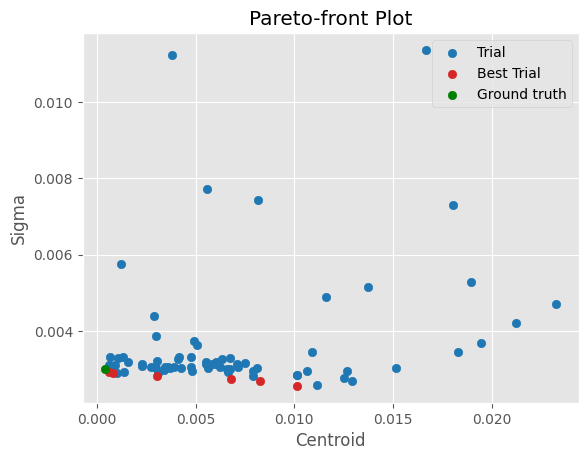

In [146]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [142]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-10.71181011216219
-10.560760231802629
-13.243768838136837
-11.67127720896053
-10.898265874630555
-12.95020535854166


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.008281520307189157, 0.002690356956194155] 5.425451996537746
BeamParameterOutput(parameter_value=0.008314963205052385, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f97e88ec9d0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f983c7e2cd0>, dw=<orangecontrib.

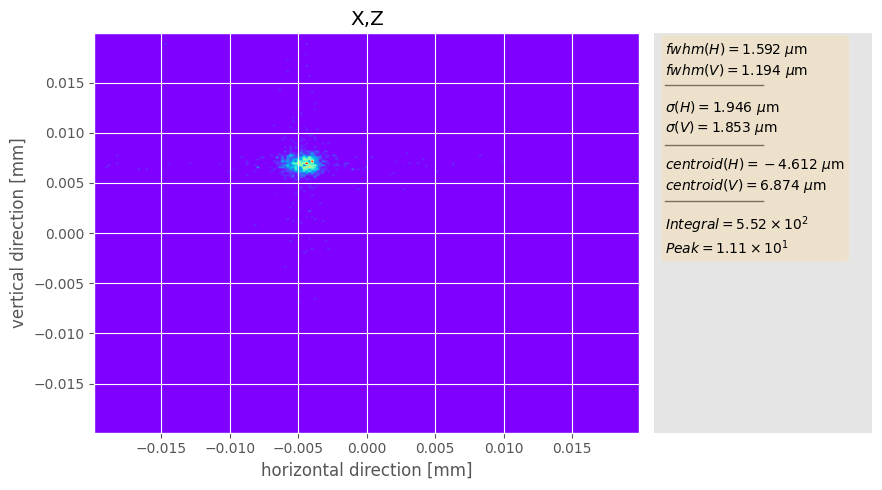

[0.0101281527448441, 0.0025585261740202108] 4.354181258242725
BeamParameterOutput(parameter_value=0.010237258337546259, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f97e9266850>, hist=<aps_ai.common.util.common.Histogram object at 0x7f9819e6f6a0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f9819354640>)


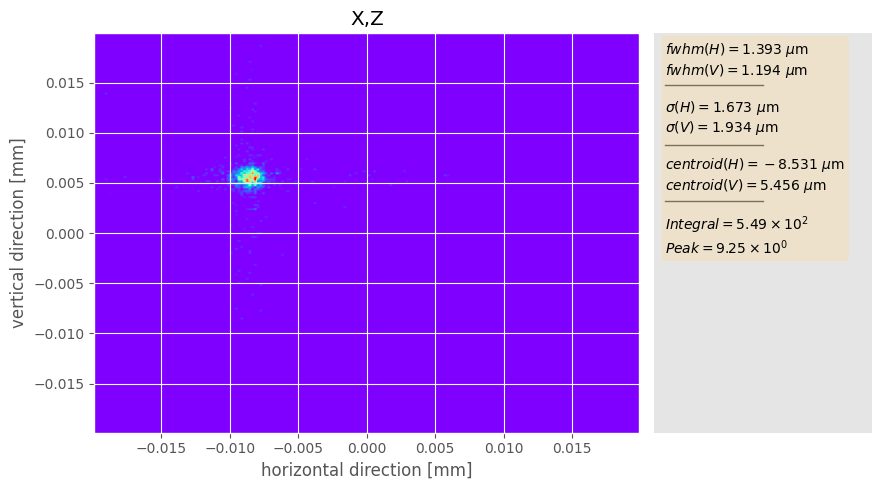

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0006057016859658535, 0.0029244586929743606] 0.8852801181655064
BeamParameterOutput(parameter_value=0.0006055442475379631, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f983fc235b0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f981cec8f10>, dw=<orangecont

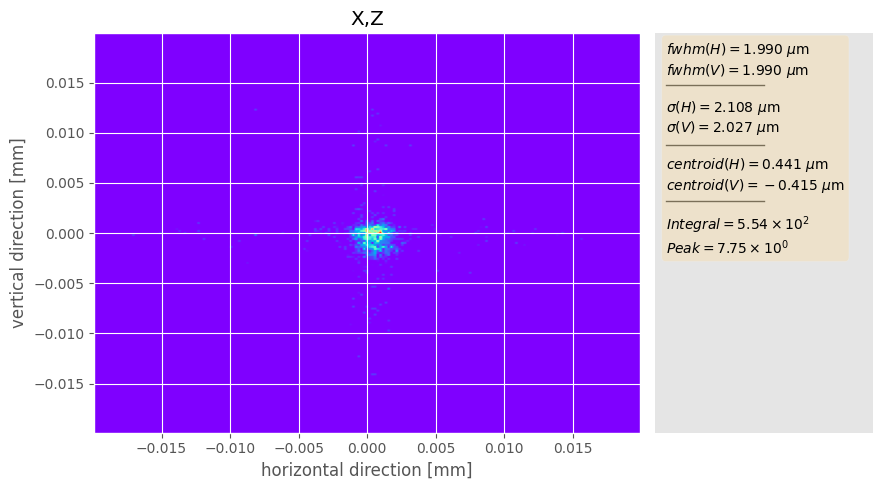

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.003035838125300497, 0.002811577768722957] 2.0495960901613275
BeamParameterOutput(parameter_value=0.0030376999666951493, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f9819964af0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f983f048fd0>, dw=<orangecontri

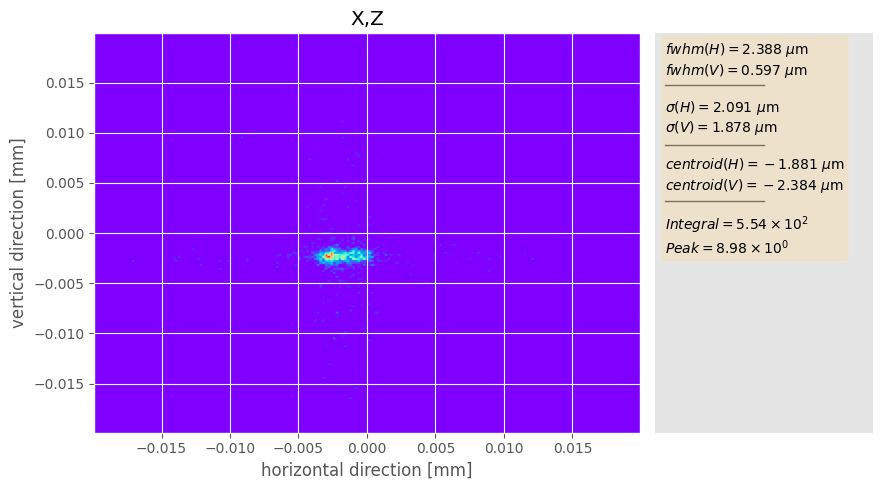

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.006777111671129099, 0.0027283408559081175] 2.1692532041718904
BeamParameterOutput(parameter_value=0.006916303539107318, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f983fb8d0a0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f983aa6d3a0>, dw=<orangecontri

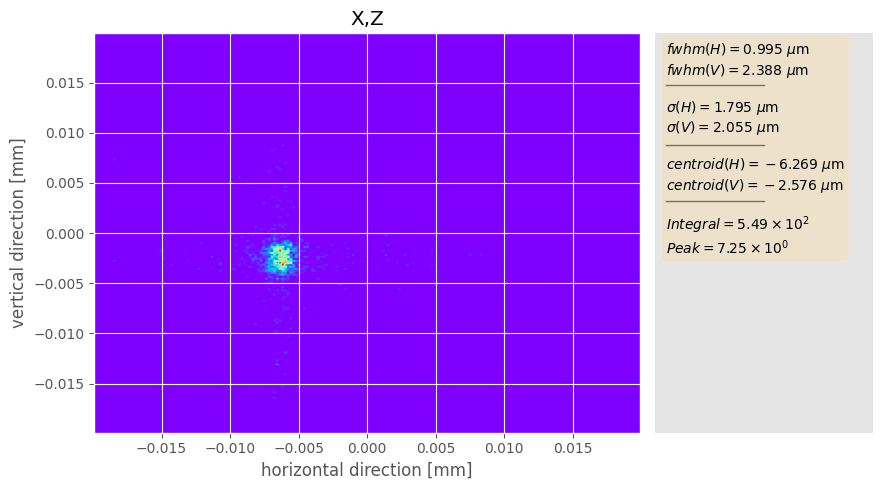

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0008227985792255739, 0.002887378645357586] 1.029835468513113
BeamParameterOutput(parameter_value=0.000822966290027961, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f981bbe0610>, hist=<aps_ai.common.util.common.Histogram object at 0x7f983f13bc70>, dw=<orangecontrib

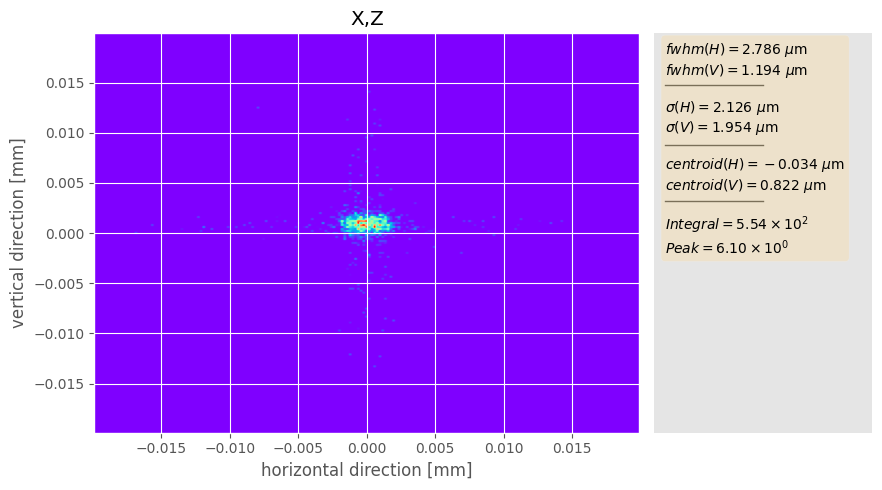

In [145]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [147]:
opt_trial.enquopt_trial.study.best_trials[2]

FrozenTrial(number=62, values=[0.0006057016859658535, 0.0029244586929743606], datetime_start=datetime.datetime(2022, 10, 15, 23, 43, 28, 943209), datetime_complete=datetime.datetime(2022, 10, 15, 23, 43, 31, 914598), params={'hkb_1': 11.376099999999994, 'vkb_1': 13.016099999999994, 'hkb_2': -10.180200000000003, 'vkb_2': 20.244799999999998, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.015565390472079388, 'hkb_4': -10.599999999999998, 'vkb_4': -7.299999999999997}, distributions={'hkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'v

In [80]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

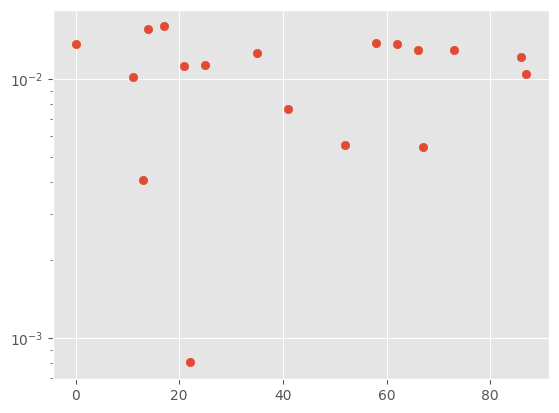

In [81]:
plt.scatter(tnums, centroids)
plt.yscale('log')

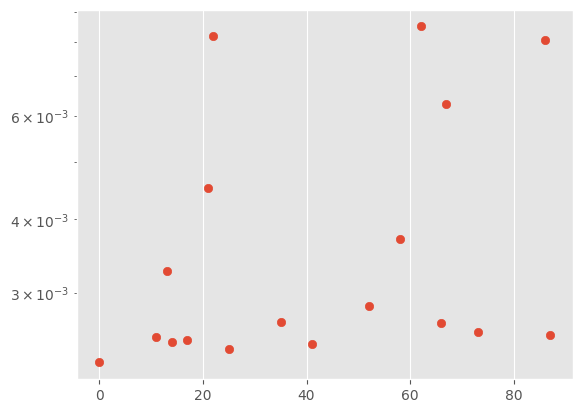

In [82]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

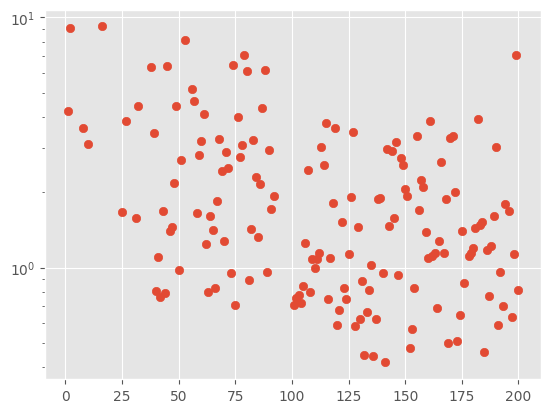

In [49]:
plt.scatter(tnums, wsums)
plt.yscale('log')

[0.0006057016859658535, 0.0029244586929743606] 0.8852801181655064


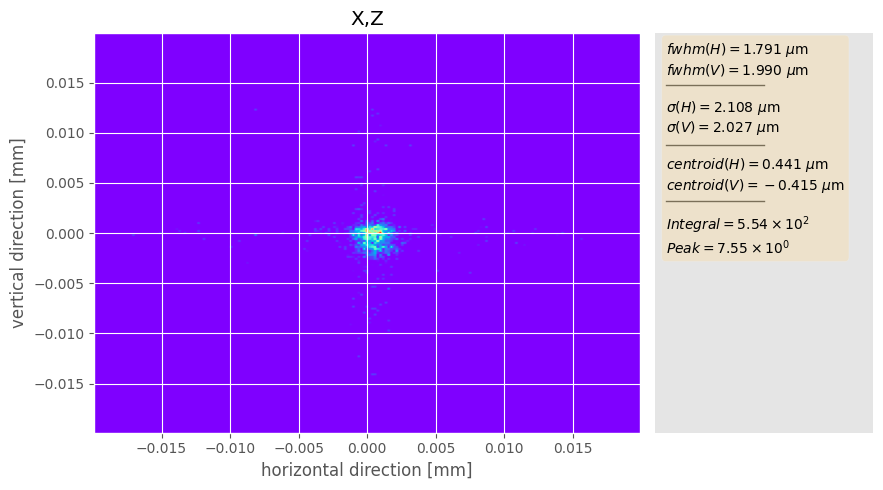

In [149]:
t = opt_trial.study.best_trials[2]
params = t.params
vals = t.values
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(t.values, t.user_attrs['wsum'])
plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

### Step 2

In [152]:
move_motors_ranges

{'hkb_1': [-30, 30],
 'vkb_1': [-30, 30],
 'hkb_2': [-30, 30],
 'vkb_2': [-30, 30],
 'hkb_3': [-0.04, 0.04],
 'vkb_3': [-0.04, 0.04],
 'hkb_4': [-30, 30],
 'vkb_4': [-30, 30]}

In [153]:
move_motor_ranges_short = {k: [v[0] / 4, v[1] / 4] for k, v in move_motors_ranges.items()}

In [156]:
move_motor_ranges_short

{'hkb_1': [-7.5, 7.5],
 'vkb_1': [-7.5, 7.5],
 'hkb_2': [-7.5, 7.5],
 'vkb_2': [-7.5, 7.5],
 'hkb_3': [-0.01, 0.01],
 'vkb_3': [-0.01, 0.01],
 'hkb_4': [-7.5, 7.5],
 'vkb_4': [-7.5, 7.5]}

In [174]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [175]:
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-5e-4,-1e-3]}, seed=111)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/1890713358.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-5e-4,-1e-3]}, seed=111)


In [176]:
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    integral_threshold=100,
    base_sampler=base_sampler,
    raise_prune_exception=True,
    use_discrete_space=True
)

[I 2022-10-16 00:07:14,952] A new study created in memory with name: no-name-f27f62c6-e874-4134-80af-f0acc08ce481


In [196]:
opt_trial.trials(200)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:07:44,058] Trial 503 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:07:57,002] Trial 504 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:08:09,635] Trial 505 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:08:22,124] Trial 506 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:08:33,885] Trial 507 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:08:45,962] Trial 508 finished with values: [0.0031981172434066216, 0.0021610828430561084] and parameters: {'hkb_1': -26.2405, 'vkb_1': 13.544599999999996, 'hkb_2': -28.6629, 'vkb_2': -0.936200000000003, 'hkb_3': 0.03853981633974483, 'vkb_3': 0.008869219055841225, 'hkb_4': 10.600000000000001, 'vkb_4': -7.099999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:08:56,887] Trial 509 finished with values: [0.0017751537218357138, 0.0019764462862182706] and parameters: {'hkb_1': -24.3712, 'vkb_1': -17.5363, 'hkb_2': 14.842299999999994, 'vkb_2': -13.7012, 'hkb_3': 0.02806784082777885, 'vkb_3': 0.02806784082777885, 'hkb_4': 4.899999999999999, 'vkb_4': -12.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:09:07,588] Trial 510 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:09:16,818] Trial 511 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:09:26,755] Trial 512 finished with values: [0.004260884113549008, 0.0021912484008572266] and parameters: {'hkb_1': -4.874000000000002, 'vkb_1': -5.930700000000002, 'hkb_2': -9.153100000000002, 'vkb_2': 20.4366, 'hkb_3': 0.03504915783575618, 'vkb_3': 0.0071238898038469, 'hkb_4': 12.100000000000001, 'vkb_4': -7.399999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:09:38,827] Trial 513 finished with values: [0.003989890198500831, 0.002409752653275553] and parameters: {'hkb_1': -26.6212, 'vkb_1': 8.381299999999996, 'hkb_2': -18.5973, 'vkb_2': 18.938699999999997, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.019056048976068045, 'hkb_4': -7.899999999999999, 'vkb_4': 5.200000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:09:55,259] Trial 514 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:10:08,179] Trial 515 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:10:23,588] Trial 516 finished with values: [0.00150247896096737, 0.002137988325687658] and parameters: {'hkb_1': 28.764899999999997, 'vkb_1': -4.705700000000004, 'hkb_2': -23.903, 'vkb_2': 19.9655, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.005378560551852568, 'hkb_4': -5.299999999999997, 'vkb_4': -4.699999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:10:34,966] Trial 517 finished with values: [0.002306835084796992, 0.0021392252737449475] and parameters: {'hkb_1': 10.453499999999998, 'vkb_1': -23.0881, 'hkb_2': -29.5365, 'vkb_2': -15.4059, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.00509341496011341, 'hkb_4': -5.299999999999997, 'vkb_4': 4.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:10:47,137] Trial 518 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:10:58,493] Trial 519 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:11:09,202] Trial 520 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:11:20,733] Trial 521 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:11:31,935] Trial 522 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:11:43,820] Trial 523 finished with values: [0.004803206021549882, 0.0021575229993003034] and parameters: {'hkb_1': 5.040799999999997, 'vkb_1': -28.6505, 'hkb_2': 22.561499999999995, 'vkb_2': -7.882800000000003, 'hkb_3': 0.014105206811824214, 'vkb_3': -0.006838744212107742, 'hkb_4': 8.900000000000006, 'vkb_4': 1.6000000000000014}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:11:55,555] Trial 524 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:12:05,539] Trial 525 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:12:16,885] Trial 526 finished with values: [0.000697373572429988, 0.0024440105741530063] and parameters: {'hkb_1': 14.176499999999997, 'vkb_1': -0.592800000000004, 'hkb_2': 29.039399999999993, 'vkb_2': 14.919399999999996, 'hkb_3': 0.03853981633974483, 'vkb_3': -0.006838744212107742, 'hkb_4': 10.300000000000004, 'vkb_4': 3.8000000000000043}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.99999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:12:30,124] Trial 527 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:12:42,407] Trial 528 finished with values: [0.0005499572396432853, 0.002149465298888952] and parameters: {'hkb_1': -3.5676000000000023, 'vkb_1': -5.0059000000000005, 'hkb_2': -18.5042, 'vkb_2': -0.15540000000000376, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.012074731968090727, 'hkb_4': -5.199999999999999, 'vkb_4': 5.200000000000003}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:12:53,457] Trial 529 finished with values: [0.00047154291130855936, 0.0024606046530829266] and parameters: {'hkb_1': -12.224400000000003, 'vkb_1': -28.7594, 'hkb_2': 27.201999999999998, 'vkb_2': -21.0607, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.0071238898038469, 'hkb_4': -7.0, 'vkb_4': -4.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:13:04,941] Trial 530 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:13:15,434] Trial 531 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:13:26,439] Trial 532 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:13:37,960] Trial 533 finished with values: [0.0036862289477113228, 0.002074444325011218] and parameters: {'hkb_1': -25.0197, 'vkb_1': -9.574200000000001, 'hkb_2': 27.723899999999993, 'vkb_2': -15.857000000000001, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.0071238898038469, 'hkb_4': 4.5, 'vkb_4': -0.09999999999999787}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:13:47,729] Trial 534 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:13:57,748] Trial 535 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:14:07,896] Trial 536 finished with values: [0.0005884413377310416, 0.002091347505438536] and parameters: {'hkb_1': 5.805799999999998, 'vkb_1': -4.935900000000004, 'hkb_2': -4.766200000000001, 'vkb_2': -29.0421, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.0071238898038469, 'hkb_4': 5.300000000000004, 'vkb_4': -3.599999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:14:20,063] Trial 537 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:14:33,341] Trial 538 finished with values: [0.005561145458729178, 0.0021431514636938783] and parameters: {'hkb_1': -19.1082, 'vkb_1': -12.250300000000003, 'hkb_2': 19.582199999999993, 'vkb_2': 15.475899999999996, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.015565390472079388, 'hkb_4': -3.8999999999999986, 'vkb_4': 4.800000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:14:45,254] Trial 539 finished with values: [0.001350572597134493, 0.002112856996878879] and parameters: {'hkb_1': 20.345999999999997, 'vkb_1': 2.9505999999999943, 'hkb_2': -3.903100000000002, 'vkb_2': -6.3922000000000025, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.005378560551852568, 'hkb_4': -5.799999999999997, 'vkb_4': -3.099999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:14:56,891] Trial 540 finished with values: [0.003086304692022583, 0.0021662139872972923] and parameters: {'hkb_1': -20.9362, 'vkb_1': 11.786499999999997, 'hkb_2': 12.535199999999996, 'vkb_2': -19.5177, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.005378560551852568, 'hkb_4': 8.100000000000001, 'vkb_4': -5.299999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:15:06,745] Trial 541 finished with values: [0.0029183852141067977, 0.005886466900649951] and parameters: {'hkb_1': -8.545700000000004, 'vkb_1': 13.720799999999997, 'hkb_2': -7.648000000000003, 'vkb_2': -28.6878, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.008869219055841225, 'hkb_4': 6.200000000000003, 'vkb_4': 17.1}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:15:17,860] Trial 542 finished with values: [0.0007725717040417178, 0.002349109000487519] and parameters: {'hkb_1': 8.492399999999996, 'vkb_1': 8.159799999999997, 'hkb_2': -6.055700000000002, 'vkb_2': 26.910599999999995, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.008869219055841225, 'hkb_4': -4.899999999999999, 'vkb_4': -4.799999999999997}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:15:29,201] Trial 543 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:15:41,597] Trial 544 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:15:54,111] Trial 545 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:16:05,159] Trial 546 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:16:16,917] Trial 547 finished with values: [0.0004459068067409736, 0.0021151580769039205] and parameters: {'hkb_1': -23.1308, 'vkb_1': -9.1234, 'hkb_2': 5.274899999999995, 'vkb_2': 16.3859, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.0071238898038469, 'hkb_4': -5.399999999999999, 'vkb_4': -4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:16:29,786] Trial 548 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:16:42,099] Trial 549 finished with values: [0.0026891730581752814, 0.002206925005372416] and parameters: {'hkb_1': -4.907800000000002, 'vkb_1': 25.817999999999998, 'hkb_2': 0.893699999999999, 'vkb_2': 14.591899999999995, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.03155849933176751, 'hkb_4': -5.5, 'vkb_4': -14.7}. 


In [197]:
opt_trial.study.best_trials

[FrozenTrial(number=134, values=[0.0003784096100713016, 0.002080623296130252], datetime_start=datetime.datetime(2022, 10, 16, 0, 14, 28, 764977), datetime_complete=datetime.datetime(2022, 10, 16, 0, 14, 33, 222320), params={'hkb_1': 3.2883999999999958, 'vkb_1': -17.2253, 'hkb_2': -3.167500000000004, 'vkb_2': 21.2628, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.010614548307835557, 'hkb_4': -4.599999999999998, 'vkb_4': -6.199999999999999}, distributions={'hkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


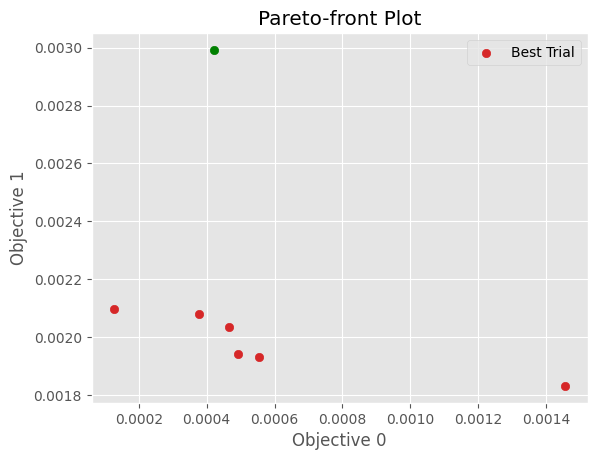

In [198]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [199]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-14.054621093072088 0.63004402183386
-15.135783170427676 0.624133680202069
-13.85962392736716 0.5835834579983169
-13.868816543498674 0.7346887928725351
-12.834141598890842 1.2180467809169364
-13.749816110217541 0.6921631519874407


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0003784096100713016, 0.002080623296130252] 0.63004402183386


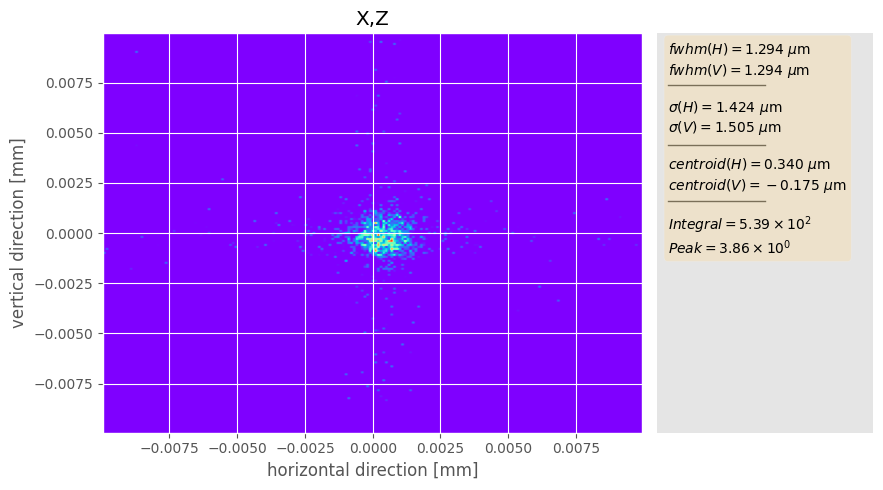

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.00012734514956073474, 0.0020971547671807425] 0.624133680202069


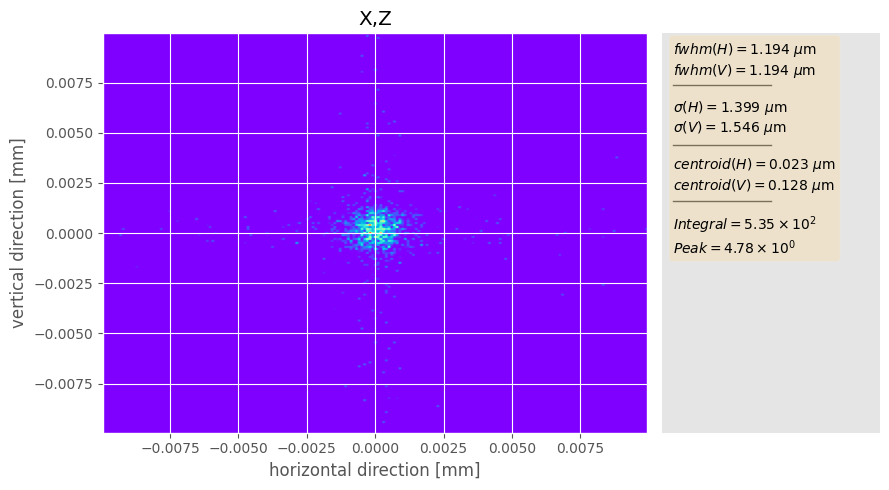

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0004929527526772895, 0.0019410490541476864] 0.5835834579983169


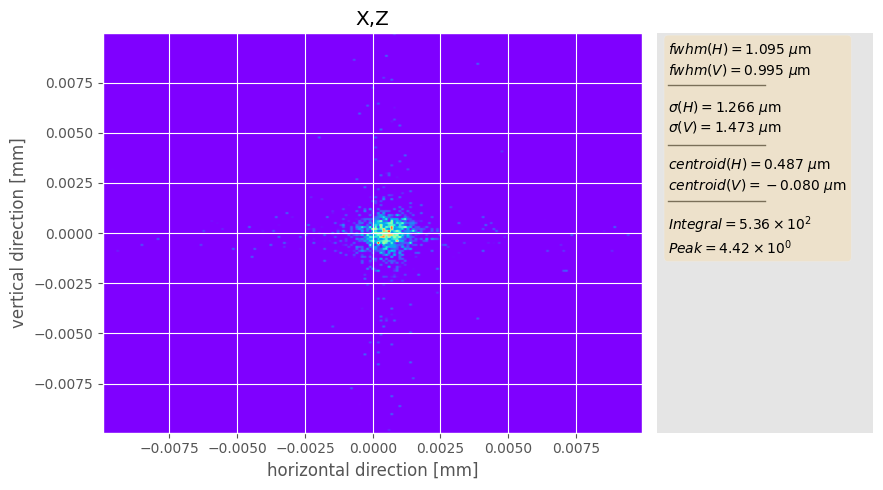

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0004656678320446019, 0.002035978869631447] 0.7346887928725351


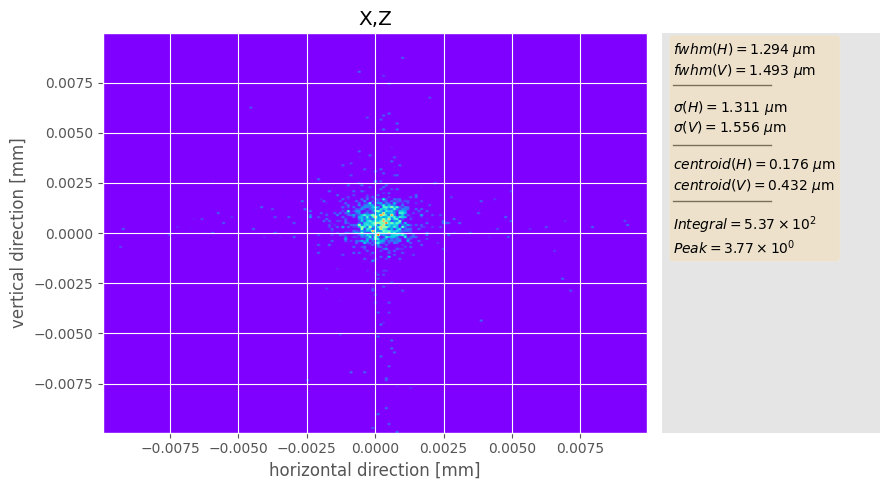

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0014566210866197105, 0.0018317092178513272] 1.2180467809169364


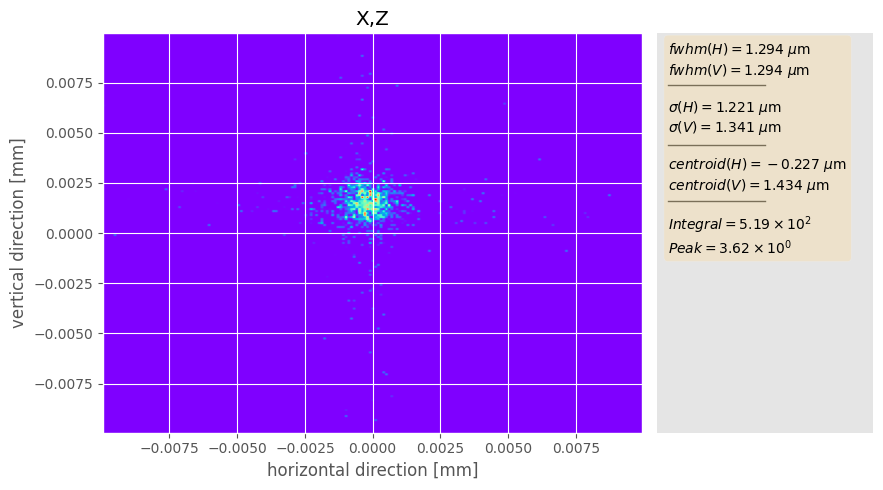

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0005532747126930859, 0.001930144905319144] 0.6921631519874407


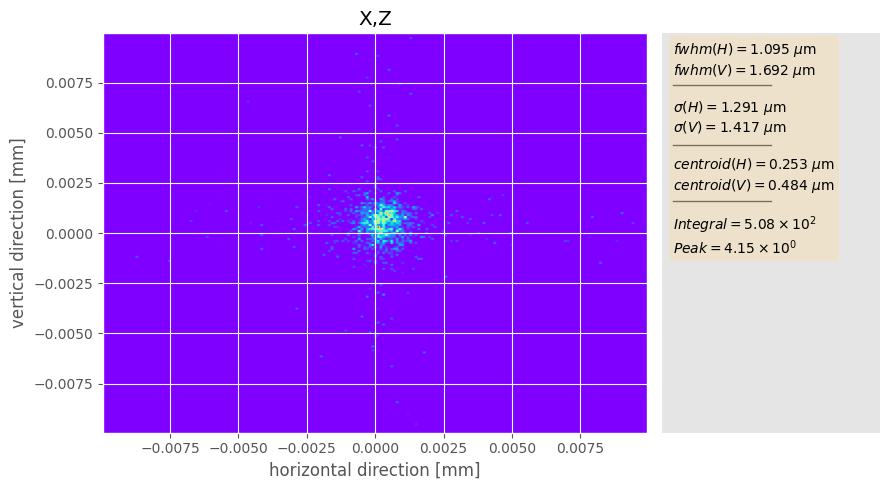

In [200]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.00012734514956073474, 0.0020971547671807425] 0.624133680202069


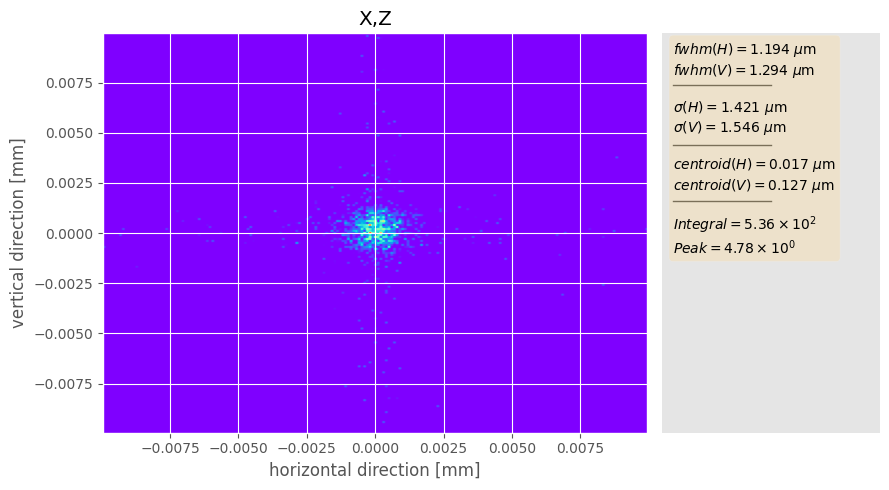

In [201]:
t = opt_trial.study.best_trials[1]
params = t.params
vals = t.values
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(t.values, t.user_attrs["wsum"])
plot_shadow_beam_spatial_distribution(
    opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange
)

In [202]:
movers.get_absolute_positions(focusing_system, motors=list(move_motor_ranges_short.keys()))

[233.3204999999999,
 148.19120000000004,
 101.02560000000037,
 252.13669999999988,
 2.9738200612201355,
 2.996509341496062,
 3.4227476931689473,
 -7.034127432230161]

In [203]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])

In [205]:
opt_trial._camera_xrange = [-0.005, 0.005]
opt_trial._camera_yrange = [-0.005, 0.005]

In [206]:
opt_trial.trials(50)

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:19:28,742] Trial 550 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:19:40,722] Trial 551 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:19:52,072] Trial 552 finished with values: [0.002312087768509935, 0.001511230574851747] and parameters: {'hkb_1': -21.0059, 'vkb_1': 8.259099999999997, 'hkb_2': -16.053400000000003, 'vkb_2': -29.0377, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.03504915783575618, 'hkb_4': -10.099999999999998, 'vkb_4': -15.2}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:20:11,167] Trial 553 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:20:27,178] Trial 554 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-16 01:20:49,752] Trial 555 pruned. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)

KeyboardInterrupt



In [197]:
opt_trial.study.best_trials

[FrozenTrial(number=134, values=[0.0003784096100713016, 0.002080623296130252], datetime_start=datetime.datetime(2022, 10, 16, 0, 14, 28, 764977), datetime_complete=datetime.datetime(2022, 10, 16, 0, 14, 33, 222320), params={'hkb_1': 3.2883999999999958, 'vkb_1': -17.2253, 'hkb_2': -3.167500000000004, 'vkb_2': 21.2628, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.010614548307835557, 'hkb_4': -4.599999999999998, 'vkb_4': -6.199999999999999}, distributions={'hkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=29.999999999999993, log=False, low=-30.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_54407/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


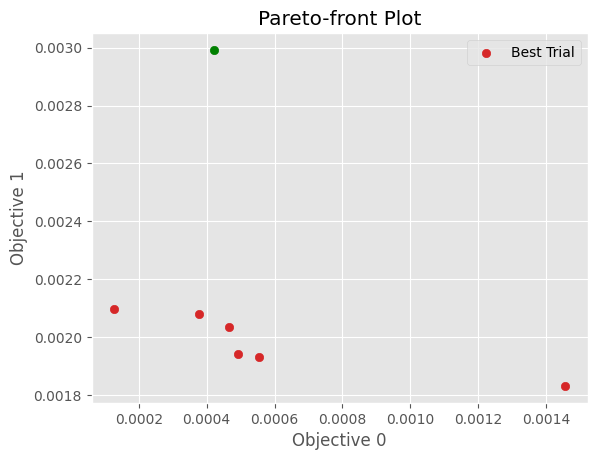

In [198]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [199]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-14.054621093072088 0.63004402183386
-15.135783170427676 0.624133680202069
-13.85962392736716 0.5835834579983169
-13.868816543498674 0.7346887928725351
-12.834141598890842 1.2180467809169364
-13.749816110217541 0.6921631519874407


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0003784096100713016, 0.002080623296130252] 0.63004402183386


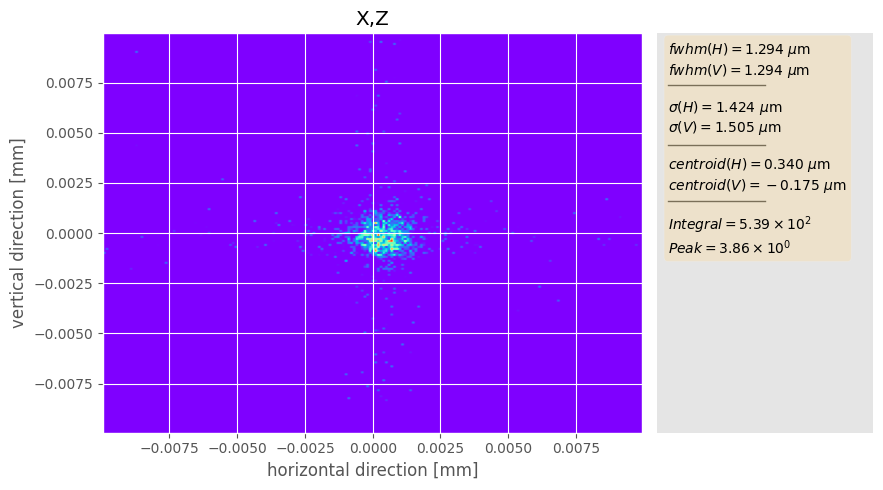

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.00012734514956073474, 0.0020971547671807425] 0.624133680202069


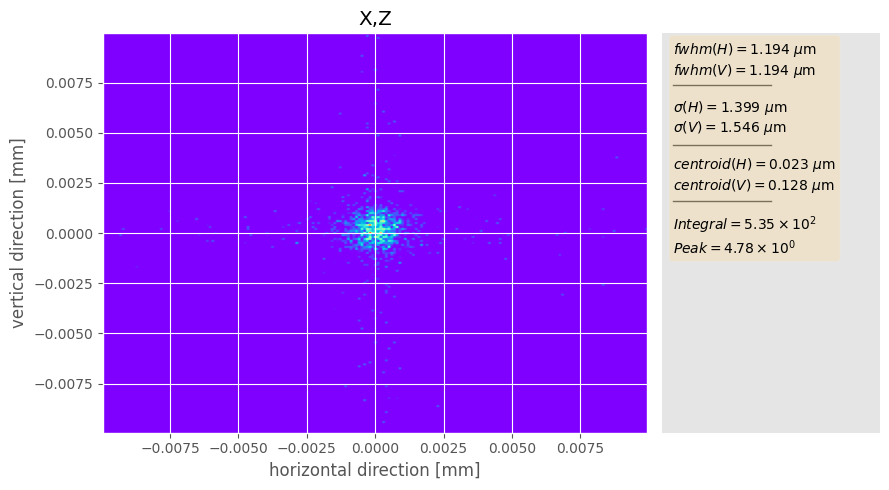

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0004929527526772895, 0.0019410490541476864] 0.5835834579983169


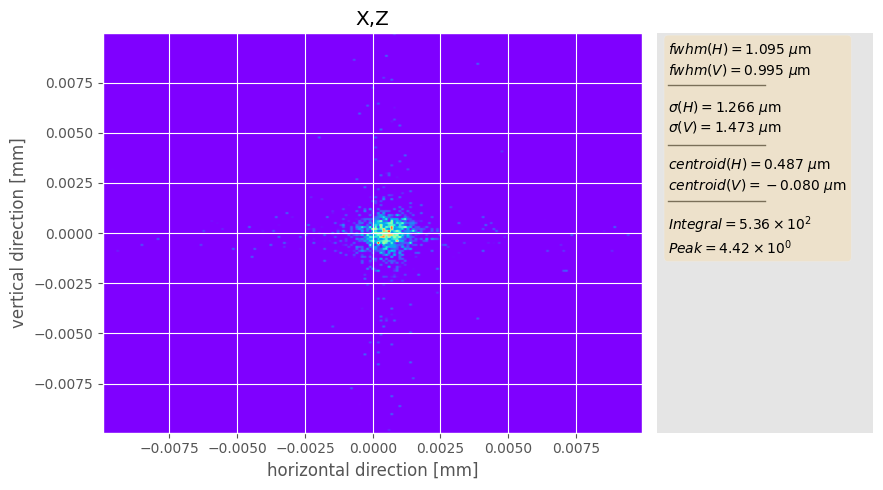

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0004656678320446019, 0.002035978869631447] 0.7346887928725351


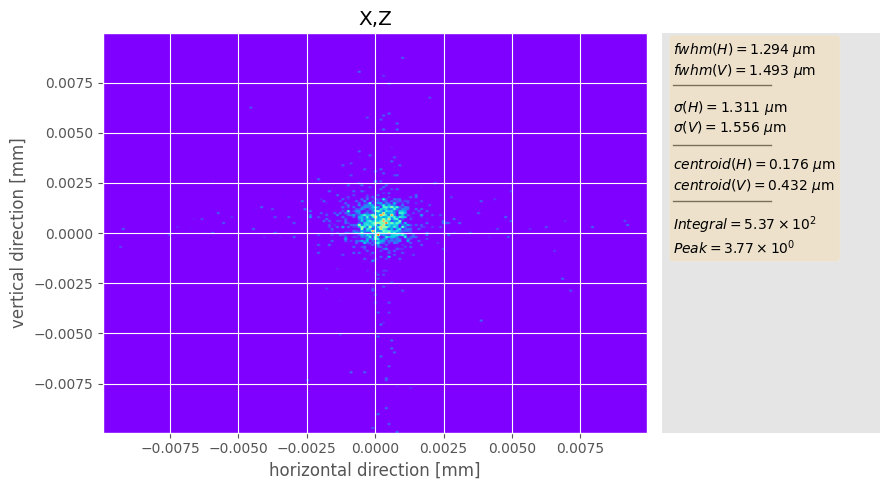

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0014566210866197105, 0.0018317092178513272] 1.2180467809169364


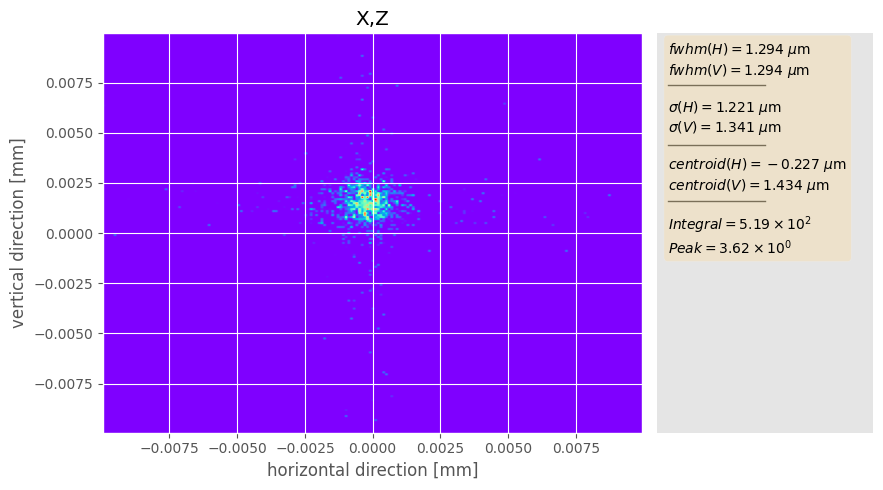

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.0005532747126930859, 0.001930144905319144] 0.6921631519874407


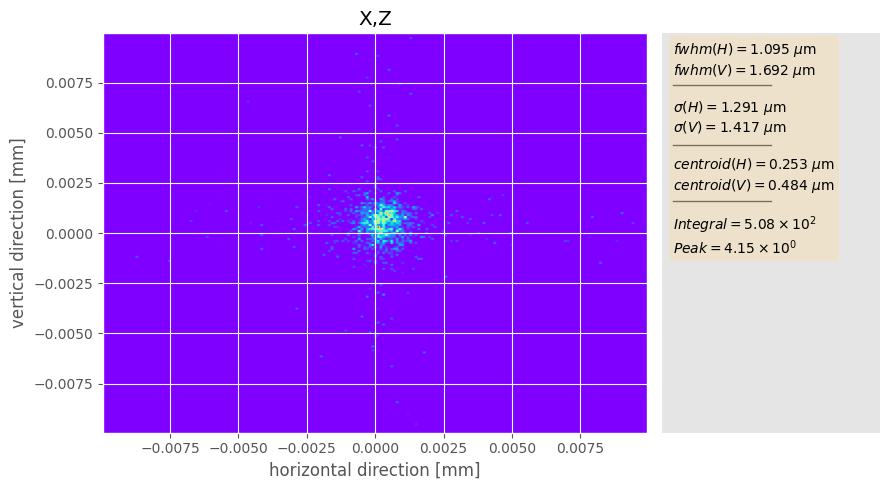

In [200]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41814/Downstream_HKB_bender_profile.dat written to disk.
[0.00012734514956073474, 0.0020971547671807425] 0.624133680202069


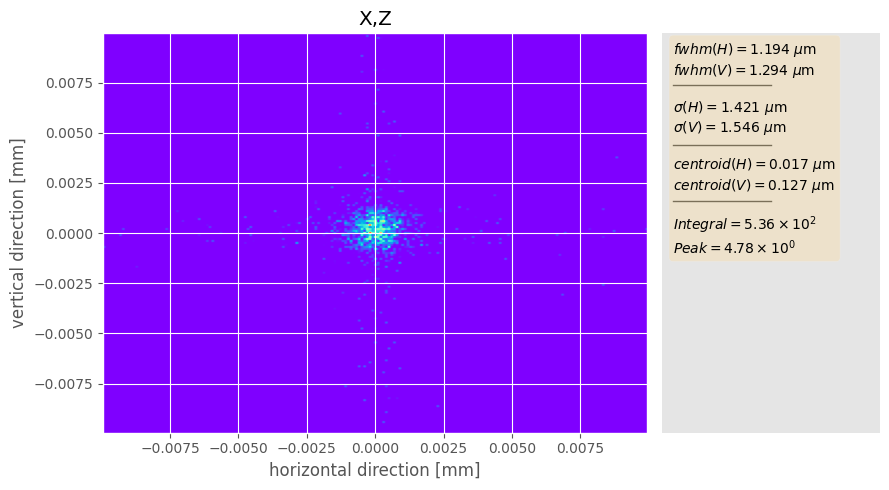

In [201]:
t = opt_trial.study.best_trials[1]
params = t.params
vals = t.values
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(t.values, t.user_attrs["wsum"])
plot_shadow_beam_spatial_distribution(
    opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange
)

In [202]:
movers.get_absolute_positions(focusing_system, motors=list(move_motor_ranges_short.keys()))

[233.3204999999999,
 148.19120000000004,
 101.02560000000037,
 252.13669999999988,
 2.9738200612201355,
 2.996509341496062,
 3.4227476931689473,
 -7.034127432230161]

In [203]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])